**Setting up the Environment**

In [1]:
!pip install tensorflow keras flask kaggle

In [2]:
from google.colab import files

# This will prompt you to upload the kaggle.json file
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
import os
import shutil

# Create the .kaggle directory if it doesn't exist
kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

# Move the uploaded kaggle.json to the .kaggle directory
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(kaggle_dir, filename))

# Set permissions for the kaggle.json file
os.chmod(os.path.join(kaggle_dir, 'kaggle.json'), 0o600)

In [4]:
!kaggle datasets download -d saailna/war-events-classification

Dataset URL: https://www.kaggle.com/datasets/saailna/war-events-classification
License(s): MIT
war-events-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip /content/war-events-classification.zip

Archive:  /content/war-events-classification.zip
replace war_events/Combat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define paths
data_dir = '/content/war_events' # Ensure your images are in subdirectories for each class

# Prepare dataset lists
image_paths = []
labels = []

# data_dir has subdirectories for each class
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

# Convert labels to numerical values
label_to_index = {label: idx for idx, label in enumerate(set(labels))}
labels = [label_to_index[label] for label in labels]

# Split the dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data augmentation and preprocessing
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return img_array

def data_generator(paths, labels, batch_size, is_train):
    data_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if is_train else ImageDataGenerator()

    while True:
        for start in range(0, len(paths), batch_size):
            end = min(start + batch_size, len(paths))
            batch_paths = paths[start:end]
            batch_labels = labels[start:end]

            batch_images = np.array([preprocess_image(img_path) for img_path in batch_paths])
            batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(label_to_index))

            if is_train:
                yield next(data_gen.flow(batch_images, batch_labels, batch_size=batch_size))
            else:
                yield batch_images, batch_labels

batch_size = 32

train_gen = data_generator(train_paths, train_labels, batch_size, is_train=True)
val_gen = data_generator(val_paths, val_labels, batch_size, is_train=False)

# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(label_to_index), activation='softmax')  # Adjust the number of classes dynamically
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=20
)

# Save the model
model.save('war_lens_model_resnet50.h5')


Epoch 1/20
12/12 [==============================] - 139s 11s/step - loss: 15.9469 - accuracy: 0.2005 - val_loss: 4.5750 - val_accuracy: 0.1979
Epoch 2/20
12/12 [==============================] - 110s 9s/step - loss: 2.6478 - accuracy: 0.3152 - val_loss: 1.6185 - val_accuracy: 0.4559
Epoch 3/20
12/12 [==============================] - 108s 9s/step - loss: 1.7286 - accuracy: 0.3723 - val_loss: 1.4072 - val_accuracy: 0.3824
Epoch 4/20
12/12 [==============================] - 107s 9s/step - loss: 1.4118 - accuracy: 0.3777 - val_loss: 1.3793 - val_accuracy: 0.4265
Epoch 5/20
12/12 [==============================] - 103s 9s/step - loss: 1.3041 - accuracy: 0.4674 - val_loss: 1.2268 - val_accuracy: 0.4559
Epoch 6/20
12/12 [==============================] - 110s 9s/step - loss: 1.3147 - accuracy: 0.4647 - val_loss: 1.4095 - val_accuracy: 0.3824
Epoch 7/20
12/12 [==============================] - 106s 9s/step - loss: 1.3526 - accuracy: 0.4348 - val_loss: 1.4803 - val_accuracy: 0.3529
Epoch 8/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define paths
data_dir = '/content/war_events'  # Ensure your images are in subdirectories for each class

# Prepare dataset lists
image_paths = []
labels = []

# data_dir has subdirectories for each class
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

# Convert labels to numerical values
label_to_index = {label: idx for idx, label in enumerate(set(labels))}
labels = [label_to_index[label] for label in labels]

# Split the dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Data augmentation and preprocessing
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return img_array

def data_generator(paths, labels, batch_size, is_train):
    data_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if is_train else ImageDataGenerator(rescale=1./255)

    while True:
        for start in range(0, len(paths), batch_size):
            end = min(start + batch_size, len(paths))
            batch_paths = paths[start:end]
            batch_labels = labels[start:end]

            batch_images = np.array([preprocess_image(img_path) for img_path in batch_paths])
            batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=len(label_to_index))

            if is_train:
                yield next(data_gen.flow(batch_images, batch_labels, batch_size=batch_size))
            else:
                yield batch_images, batch_labels

batch_size = 32

train_gen = data_generator(train_paths, train_labels, batch_size, is_train=True)
val_gen = data_generator(val_paths, val_labels, batch_size, is_train=False)

# Load pre-trained MobileNetV2 model + higher level layers
mobilenet_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pretrained layers
mobilenet_model.trainable = False

# Create a new model on top
model_new1 = Sequential([
    mobilenet_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_to_index), activation='softmax')  # Adjust the number of classes dynamically
])

# Compile the model
model_new1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_new1 = model_new1.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=20
)

# Save the model
model_new1.save('war_lens_model_mobilenetv2.h5')

# Evaluate the model
val_loss, val_accuracy = model_new1.evaluate(val_gen, steps=len(val_paths) // batch_size)
print(f'Validation accuracy: {val_accuracy}')


Epoch 1/20
12/12 [==============================] - 40s 3s/step - loss: 1.4525 - accuracy: 0.4844 - val_loss: 0.5592 - val_accuracy: 0.8229
Epoch 2/20
12/12 [==============================] - 30s 3s/step - loss: 0.7163 - accuracy: 0.7663 - val_loss: 0.4132 - val_accuracy: 0.8676
Epoch 3/20
12/12 [==============================] - 28s 2s/step - loss: 0.4721 - accuracy: 0.8397 - val_loss: 0.2712 - val_accuracy: 0.8971
Epoch 4/20
12/12 [==============================] - 28s 2s/step - loss: 0.3550 - accuracy: 0.8750 - val_loss: 0.2519 - val_accuracy: 0.8824
Epoch 5/20
12/12 [==============================] - 29s 2s/step - loss: 0.2780 - accuracy: 0.9212 - val_loss: 0.2339 - val_accuracy: 0.8824
Epoch 6/20
12/12 [==============================] - 29s 2s/step - loss: 0.3039 - accuracy: 0.9022 - val_loss: 0.2461 - val_accuracy: 0.9118
Epoch 7/20
12/12 [==============================] - 29s 3s/step - loss: 0.2404 - accuracy: 0.9212 - val_loss: 0.2074 - val_accuracy: 0.9118
Epoch 8/20
12/12 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 3s 1s/step - loss: 0.2197 - accuracy: 0.9265
Validation accuracy: 0.9264705777168274


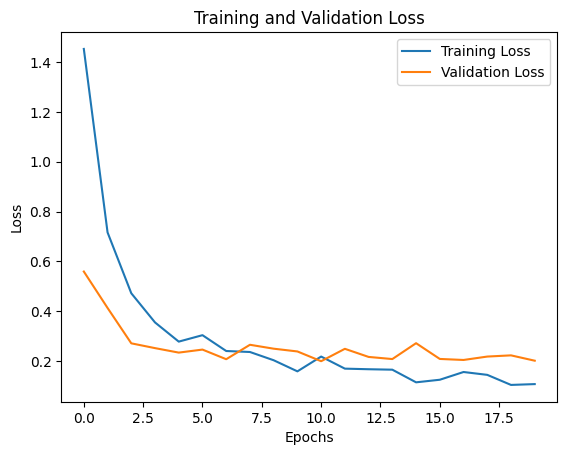

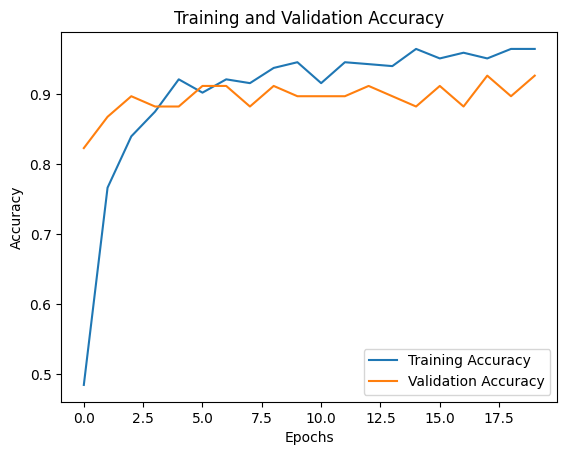

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history_new1.history['loss'], label='Training Loss')
plt.plot(history_new1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history_new1.history['accuracy'], label='Training Accuracy')
plt.plot(history_new1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

